# Credit Card Fraud Detection Project

## Introduction
The object of this project is predicting whether a credit card transaction is fraudulent for credit card companies, so that thier customers will not be charged for items that they did not purchase. 

The challenge in this project is that the dataset is extremely unbalanced, only 492 out of 284,807 transactions are fraudulent, the positive class (frauds) account for 0.172% of all transactions. 

## Overview
The dataset used in this project can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud)

Most of the features in the dataset are numerical input variables which are the result of a PCA transformation, the original features are not provided due to confidentially issues. 

* Features V1, V2, ... V28 are the principle components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
* Feature 'Time' contains the seconds elapsed between each transaction and the first transacton in that dataset. 
* Feature 'Amount' is the transaction amount. Feature 'Class' is the responsive variable and it takes value 1 in case of fraud and 0 otherwise. 

Firstly, import the libraries we need for this project: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.feature_selection import RFE

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, recall_score, precision_score, make_scorer, precision_recall_curve
from sklearn import tree
import plot_cm

from joblib import dump, load

import warnings
warnings.filterwarnings("ignore")

Then, import the dataset and name it as df, using pd.read_csv():

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Check the information of our dataset: 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Check whether there are any missing values

In [4]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Great, there is no missing value in our dataset, we do not need to deal whith missing data in feature engineering phase. 

Now check whether our dataset is balanced

In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

We can see that our data is highly imbalanced, using the imbalanced dataframe will cause the following issues: 

* **Overfitting:** Our model will assume that most of the cases are not fraudulent. But we want our model to catch the fraudulent transactions. 
* **Wrong Correlations:** We can see how each of the features influence the result by plotting the correlation matrix. However, having an imbalance dataframe will lead to wrong correlations between the class and features. 

We will deal with this problem by upsampling using SMOTE or by using weighted loss

## Feature Engineering and EDA

### Train Test Split
Split our data set before feature engineering to prevent data leakage. Since we have only a little number of positive case, we only need to split our data to training set and test set here, and we will perform cross-validation later.  

In [6]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print('Number of training samples:', len(X_train))
print('Number of test samples:', len(X_test))

Number of training samples: 227845
Number of test samples: 56962


### Feature Distributions
Next, plot the distribution of 'Time' column

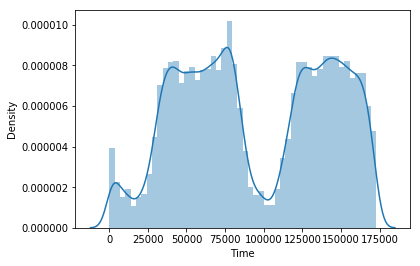

In [82]:
sns.distplot(X_train["Time"], kde=True)

Let's try to change the unit of "Time" column from second to hour

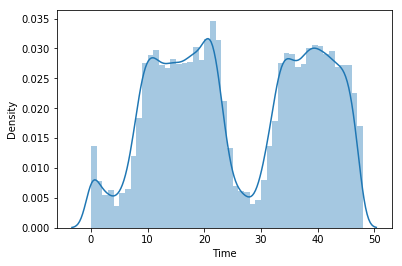

In [7]:
X_train['Time'] = X_train['Time'] // 3600
arr = range(0,49)
sns.distplot(X_train["Time"], bins = arr, kde=True)

If we change the time to hour of the day, the distribution of the feature will looks better. 

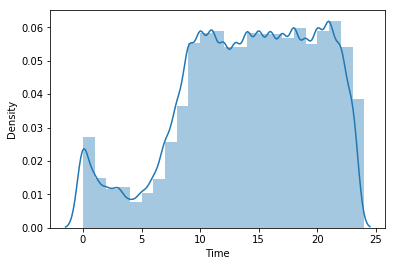

In [8]:
X_train['Time'] = X_train['Time'] % 24
arr = range(0,25)
sns.distplot(X_train["Time"], bins = arr, kde=True)

Shift the hours before 5 to the right, the distribution will be closer to normal distribution

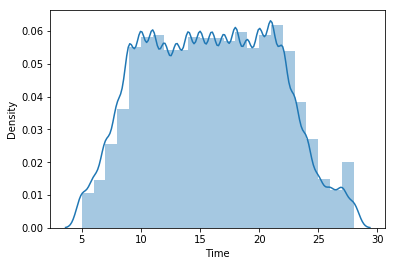

In [9]:
X_train['Time'] = X_train['Time'].apply(lambda x: x+24 if x < 5 else x)
arr = range(5,29)
sns.distplot(X_train["Time"], bins = arr, kde=True)

Perfect! The distribution is closer to normal distribution now! 

In [10]:
# Do the same process to test set
X_test['Time'] = X_test['Time'] // 3600 % 24
X_test['Time'] = X_test['Time'].apply(lambda x: x+24 if x < 5 else x)

Let's see the distributions of other features

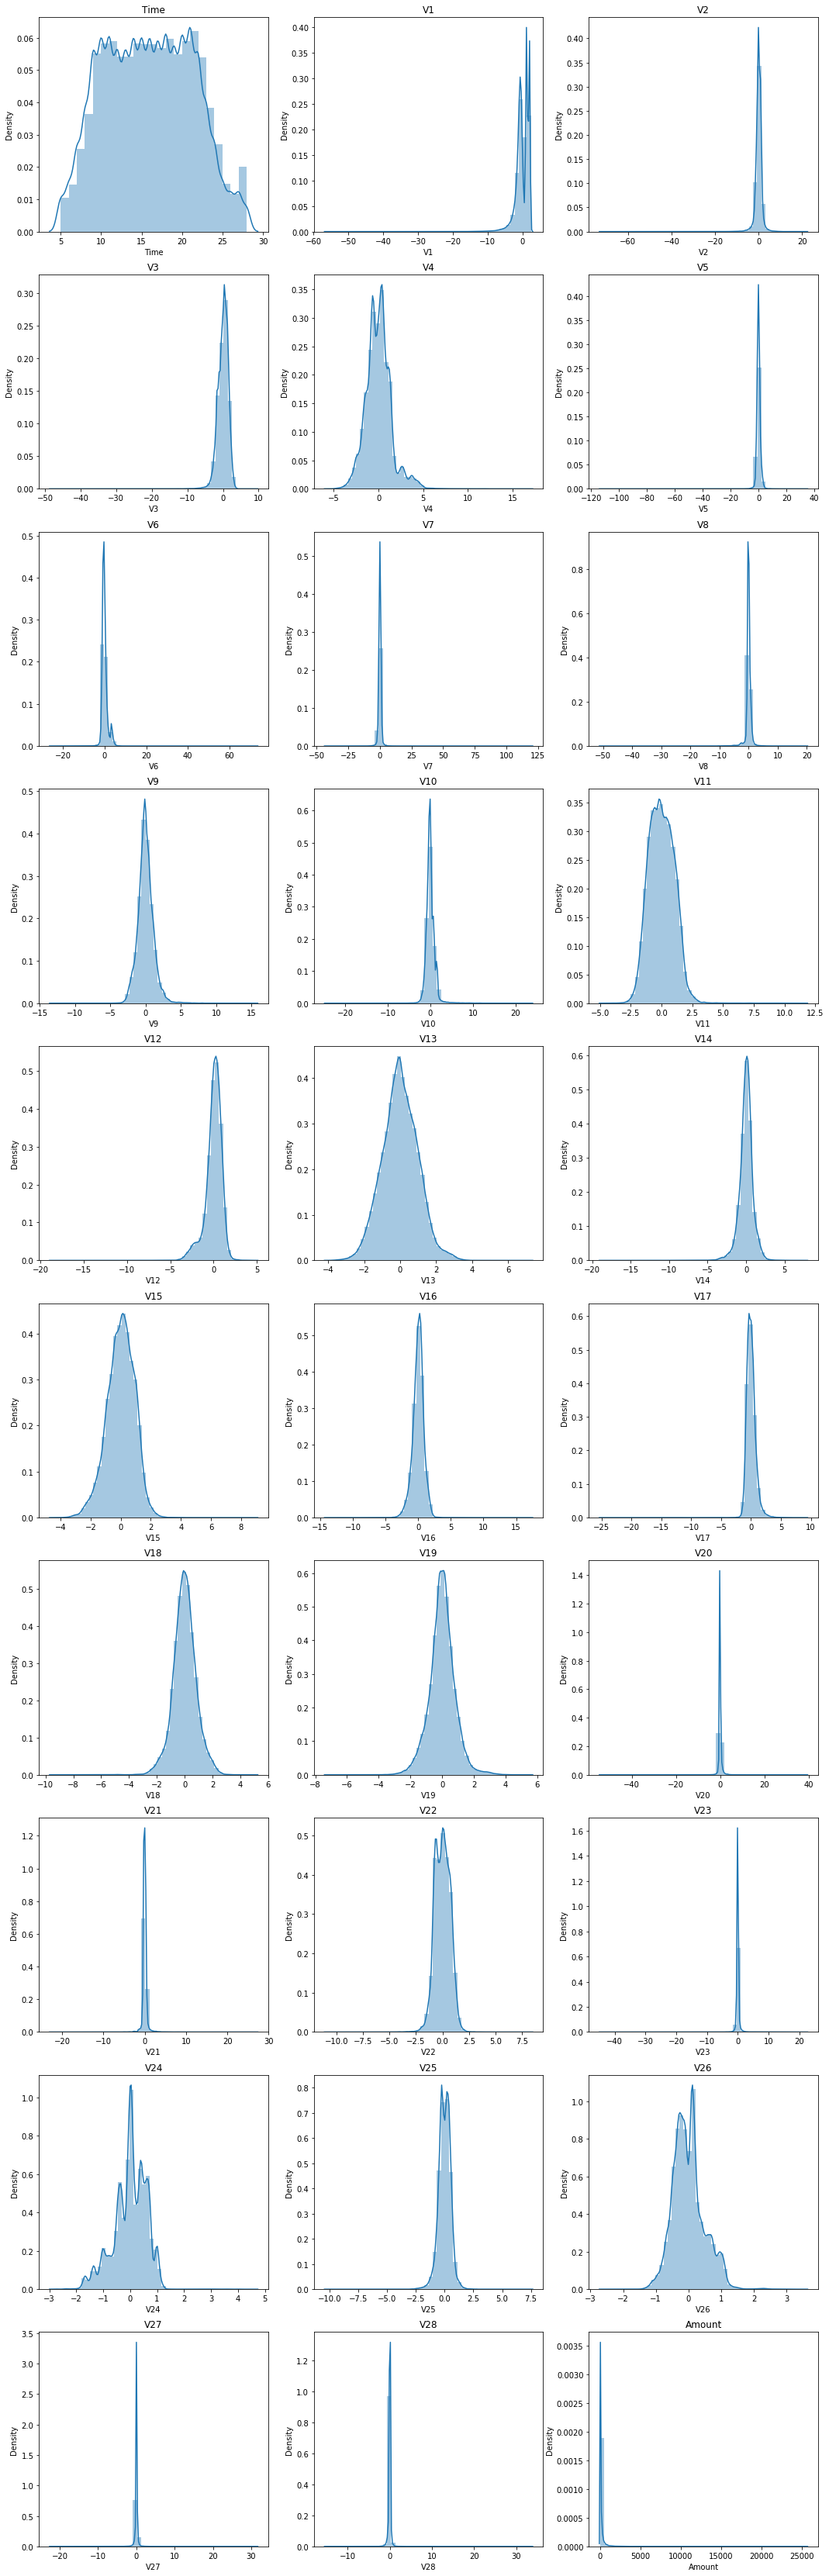

In [63]:
features = X_train.columns[0:30]
fig, axes = plt.subplots(10, 3, figsize=(18,60))
for i, feature in enumerate(features):
    ax_row, ax_column = divmod(i, 3)
    if feature == 'Time':
        arr = range(5,29)
        sns.distplot(X_train['Time'], bins = arr, kde=True, ax=axes[ax_row, ax_column])
    else:
        sns.distplot(X_train[feature], kde=True, ax=axes[ax_row, ax_column])
    axes[ax_row, ax_column].set_title(feature)

And check the standaed deviation of each feature

In [11]:
pd.set_option("max_columns", None)
X_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,15.807360,0.000475,-0.000924,-0.001514,0.000736,0.000983,0.000108,0.000484,0.000702,-0.000653,-0.000199,0.001587,-0.000231,0.000351,-0.000104,0.001442,0.000302,0.001228,-0.000387,-0.000128,-0.000940,-0.000506,0.000473,-0.000755,0.000076,0.000374,0.001134,-0.000337,-0.000294,88.282385
std,5.367392,1.964693,1.657165,1.520193,1.414580,1.382490,1.333731,1.241592,1.179057,1.098323,1.086009,1.019712,0.998961,0.994592,0.957320,0.915650,0.875372,0.849765,0.838057,0.813452,0.775991,0.724113,0.724162,0.626110,0.606005,0.521905,0.482033,0.405788,0.336761,253.884657
min,5.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-50.943369,-13.320155,-24.588262,-4.797473,-18.683715,-3.961758,-18.822087,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-22.889347,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,11.000000,-0.919655,-0.596390,-0.893646,-0.848027,-0.689998,-0.769166,-0.553790,-0.208998,-0.643257,-0.535240,-0.759981,-0.404774,-0.647473,-0.425289,-0.583483,-0.468018,-0.483598,-0.498850,-0.456763,-0.211996,-0.228300,-0.541944,-0.162016,-0.354112,-0.317463,-0.325940,-0.070919,-0.052989,5.540000
50%,16.000000,0.020168,0.066880,0.179602,-0.019995,-0.052606,-0.275052,0.040416,0.021985,-0.050818,-0.092963,-0.032812,0.138975,-0.013819,0.050366,0.049666,0.066031,-0.065104,-0.004246,0.003392,-0.062782,-0.029806,0.006855,-0.011229,0.040964,0.017268,-0.051072,0.001311,0.011182,22.000000
75%,20.000000,1.316090,0.803282,1.025827,0.742366,0.613203,0.399910,0.569882,0.327140,0.597096,0.453854,0.740921,0.617870,0.661185,0.494361,0.651197,0.523315,0.400904,0.500231,0.459493,0.132626,0.186368,0.528282,0.147305,0.439480,0.351558,0.241737,0.091012,0.077891,77.000000
max,28.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,11.619723,4.846452,7.126883,7.754599,8.877742,17.315112,9.253526,5.041069,5.501747,39.420904,27.202839,8.316275,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


We can see "Amount" feature is highly skewed, we need to power transform it to make it closer to gaussian distribution. 

In [12]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_train[['Amount']] = pt.fit_transform(X_train[['Amount']])

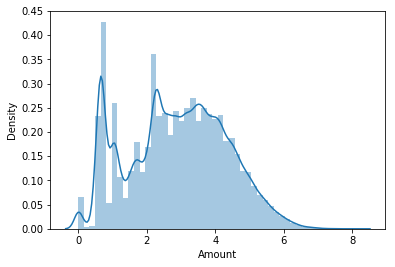

In [13]:
sns.distplot(X_train["Amount"], kde=True)

Do the same thing to the test set

In [14]:
X_test[['Amount']] = pt.fit_transform(X_test[['Amount']])

It looks more Gaussian now...

Since our features are numerical and our targets are categorical, we plot boxplots of the features to have a general idea about which feature will be important. 

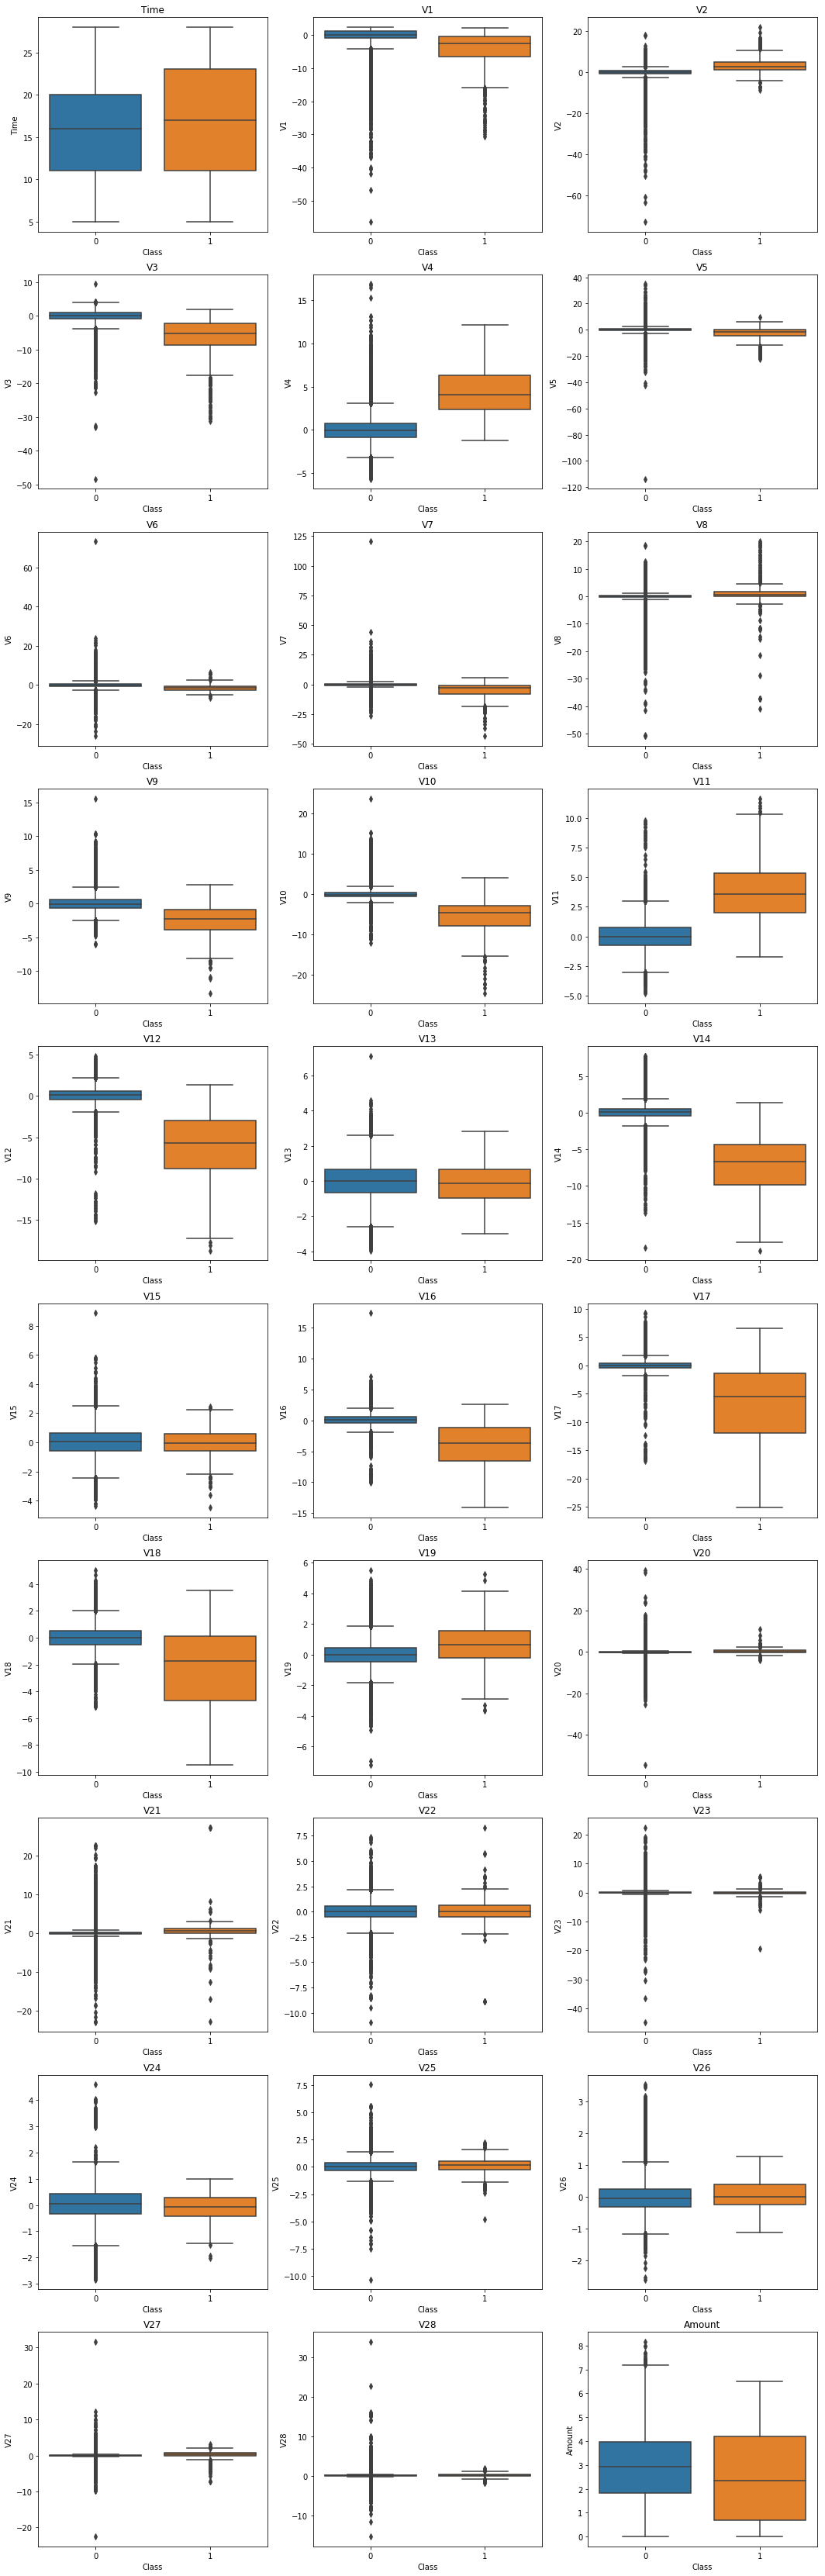

In [67]:
features = X_train.columns[0:30]
fig, axes = plt.subplots(10, 3, figsize=(18,60))
df_train = pd.concat([X_train, y_train], axis=1)
for i, feature in enumerate(features):
    ax_row, ax_column = divmod(i, 3)
    sns.boxplot(x='Class', y=feature, data=df_train, ax=axes[ax_row, ax_column])
    axes[ax_row, ax_column].set_title(feature)

## Machine learning models
We will use logistic regression as our baseline model, then compare it with support vector machine, decision tree, random forest and XGBoost. We will use 5 fold cross validation for validating and use random grid search to find the best hyperparameters based on ROC AUC score (PR AUC is better, but grid search doesn't support it), since we care more about recall and precision in this project. 

After finding the best hyperparameters, we will find the threshold with the highest F1 score, then plot the confusion matrix. 

Note that we need to validate our models on the original validation set instead of the validation set created by upsamlping. So in each fold of cross-validation, we need to split the dataset into training set and validation set before we do upsampling, and then upsample the training set.

### Logistic Regression
The pipeline of Logistic Regression including: 
1. Upsampling
2. Feature Scaling
3. Feature Selection
4. Training

In [15]:
# Need to use Pipeline from imblearn in order to do upsampling during each time of validation
LR = Pipeline([('sampling', SMOTE()),
               ('standarization', RobustScaler()),
               ('selector', SelectKBest(f_classif)),
               ('classification', LogisticRegression())])

# Inverse regularization parameters
LR_params = {'selector__k': (7,8,9,10,11), 
             'classification__C': (0.00001, 0.0001, 0.001, 0.01)}

LR_gcv = RandomizedSearchCV(estimator=LR, param_distributions=LR_params, cv=5, scoring='roc_auc')
LR_gcv.fit(X_train, y_train)

# Get the best score and the best parameter from grid search
print('Best training PR AUC score:', LR_gcv.best_score_)
print('Best parameters:', LR_gcv.best_params_)

Best training PR AUC score: 0.9782944862385292
Best parameters: {'selector__k': 11, 'classification__C': 0.001}


In [23]:
# Save LR model
dump(LR_gcv, 'LR_gcv.joblib') 

['LR_gcv.joblib']

In [45]:
# Load LR model
LR_gcv = load('LR_gcv.joblib')

Let's see which features were selected

In [16]:
LR_gcv.best_estimator_.named_steps['selector'].get_support()

array([False, False,  True,  True,  True, False, False,  True, False,
        True,  True,  True,  True, False,  True, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

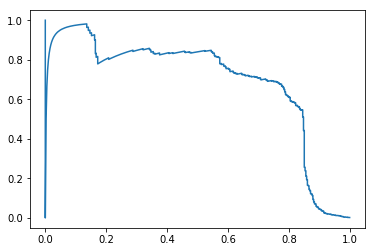

In [46]:
# Predict the probability of class equals to 1
LR_train_prob = LR_gcv.predict_proba(X_train)
LR_Pr, LR_Rc, LR_thres = precision_recall_curve(y_train, LR_train_prob[:,1])
# Plot the PR curve
plt.plot(LR_Rc, LR_Pr)

In [57]:
# See which threshold have the best weighted F1 score, since we care a little 
beta = 1.5
recall_thres = pd.concat([pd.Series(LR_thres), pd.Series(LR_Pr), pd.Series(LR_Rc), pd.Series((1+beta**2)*LR_Pr*LR_Rc/(beta**2*LR_Pr+LR_Rc))], axis=1)
recall_thres.columns = ['Threshold', 'Precision', 'Recall', 'F1 Score']

recall_thres.sort_values(by='F1 Score', ascending=False, inplace=True)
recall_thres.head()

,Threshold,Precision,Recall,F1 Score
187967,0.962404,0.677130,0.776350,0.742857
187966,0.961751,0.675615,0.776350,0.742295
187965,0.961034,0.674107,0.776350,0.741734
187956,0.956152,0.665208,0.781491,0.741603
187951,0.952148,0.660173,0.784062,0.741260


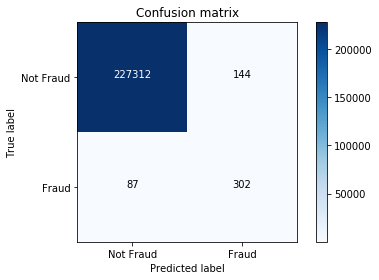

In [54]:
best_thres = recall_thres.iloc[0]['Threshold']
y_train_pred = np.where(LR_train_prob[:,1]>=best_thres,1,0)
cm = confusion_matrix(y_train, y_train_pred)
plot_cm.plot_cm(cm, classes=['Not Fraud','Fraud'])

See how Logistic Regression perform on test set: 

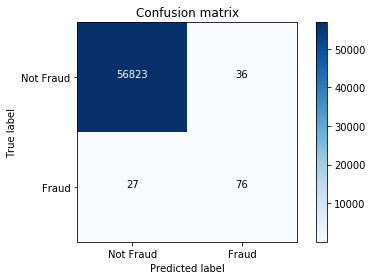

In [55]:
LR_test_prob = LR_gcv.predict_proba(X_test)
y_test_pred = np.where(LR_test_prob[:,1]>=best_thres,1,0)
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plot_cm.plot_cm(cm, classes=['Not Fraud','Fraud'])

In [50]:
print("Recall score for fraud:", recall_score(y_test, y_test_pred, pos_label=1))
print("Precision for fraud:", precision_score(y_test, y_test_pred, pos_label=1))

Recall score for fraud: 0.7378640776699029
Precision for fraud: 0.6785714285714286


The performance of Logistic Regression is not very good. Let's try some other models. 

### Decision Tree
The pipeline of Decision Tree including: 
1. Upsampling
2. Training

In [18]:
DT = Pipeline([('sampling', SMOTE()),
               ('classification', DecisionTreeClassifier())])

# Inverse regularization parameters
DT_params = {'classification__max_depth': (3, 4, 5, 6),
             'classification__min_impurity_decrease': (0, 0.02, 0.05, 0.08, 0.1)}

DT_gcv = RandomizedSearchCV(estimator=DT, param_distributions=DT_params, cv=5, scoring='roc_auc')
DT_gcv.fit(X_train, y_train)

# Get the best score and the best parameter from grid search
print('Best training ROC AUC score:', DT_gcv.best_score_)
print('Best parameters:', DT_gcv.best_params_)

Best training ROC AUC score: 0.9559913473806946
Best parameters: {'classification__min_impurity_decrease': 0, 'classification__max_depth': 4}


In [24]:
# Save LR model
dump(DT_gcv, 'DT_gcv.joblib') 

['DT_gcv.joblib']

In [39]:
# Load LR model
DT_gcv = load('DT_gcv.joblib')

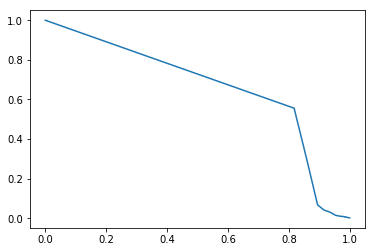

In [40]:
# Predict the probability of class equals to 1
DT_train_prob = DT_gcv.predict_proba(X_train)
DT_Pr, DT_Rc, DT_thres = precision_recall_curve(y_train, DT_train_prob[:,1])
# Plot the ROC curve
plt.plot(DT_Rc, DT_Pr)

In [41]:
# See which threshold have the best F1 score
beta = 1.5
recall_thres = pd.concat([pd.Series(DT_thres), pd.Series(DT_Pr), pd.Series(DT_Rc), pd.Series((1+beta**2)*DT_Pr*DT_Rc/(beta**2*DT_Pr+DT_Rc))], axis=1)
recall_thres.columns = ['Threshold', 'Precision', 'Recall', 'F1 Score']

recall_thres.sort_values(by='F1 Score', ascending=False, inplace=True)
recall_thres.head()

,Threshold,Precision,Recall,F1 Score
10,0.998654,0.555944,0.817481,0.714113
9,0.931623,0.300090,0.858612,0.545958
8,0.675724,0.067744,0.894602,0.188116
7,0.541286,0.042100,0.915167,0.123992
6,0.529782,0.030593,0.935733,0.092615


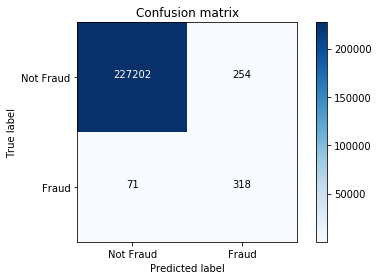

In [42]:
best_thres = recall_thres.iloc[0]['Threshold']
y_train_pred = np.where(DT_train_prob[:,1]>=best_thres,1,0)
cm = confusion_matrix(y_train, y_train_pred)
plot_cm.plot_cm(cm, classes=['Not Fraud','Fraud'])

See how decision tree performs on test set

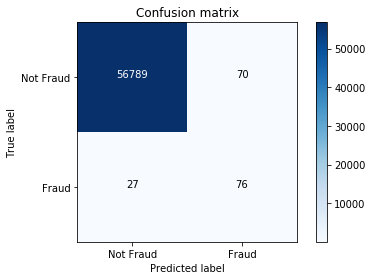

In [43]:
DT_test_prob = DT_gcv.predict_proba(X_test)
y_test_pred = np.where(DT_test_prob[:,1]>=best_thres,1,0)
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plot_cm.plot_cm(cm, classes=['Not Fraud','Fraud'])

In [44]:
print("Recall score for fraud:", recall_score(y_test, y_test_pred, pos_label=1))
print("Precision for fraud:", precision_score(y_test, y_test_pred, pos_label=1))

Recall score for fraud: 0.7378640776699029
Precision for fraud: 0.5205479452054794


Visualize the decision tree

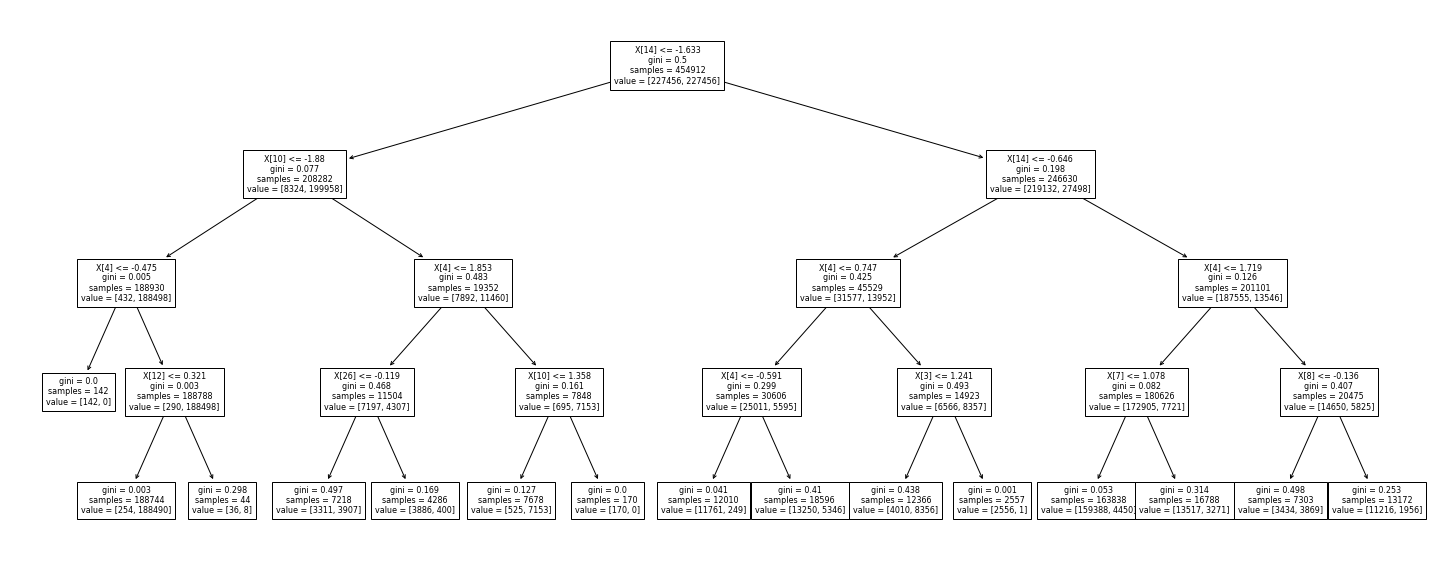

In [21]:
plt.figure(figsize=(25,10))
tree.plot_tree(DT_gcv.best_estimator_.named_steps['classification'], fontsize=8)
plt.show()

### Random Forest
The pipeline of Random Forest including: 
1. Upsampling
2. Training

In [38]:
RF = Pipeline([('sampling', SMOTE()),
                ('classification', RandomForestClassifier())])

# Inverse regularization parameters
RF_params = {'classification__max_depth': (3, 4, 5, 6),
             'classification__n_estimators': (25,50,75,100)}

RF_gcv = RandomizedSearchCV(estimator=RF, param_distributions=RF_params, cv=5, scoring='roc_auc', verbose=10)
RF_gcv.fit(X_train, y_train)

# Get the best score and the best parameter from grid search
print('Best training ROC AUC score:', RF_gcv.best_score_)
print('Best parameters:', RF_gcv.best_params_)

Best training ROC AUC score: 0.9829566717612975
Best parameters: {'classification__n_estimators': 100, 'classification__max_depth': 5}


In [17]:
# Save RF model
dump(RF_gcv, 'RF_gcv.joblib') 

['RF_gcv.joblib']

In [ ]:
# Load RF model
RF_gcv = load('RF_gcv.joblib')

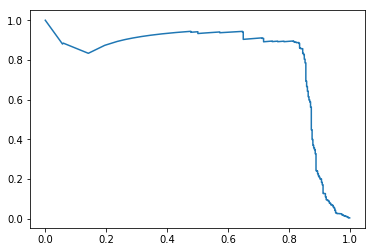

In [18]:
# Predict the probability of class equals to 1
RF_train_prob = RF_gcv.predict_proba(X_train)
RF_Pr, RF_Rc, RF_thres = precision_recall_curve(y_train, RF_train_prob[:,1])
# Plot the PR curve
plt.plot(RF_Rc, RF_Pr)

In [34]:
# See which threshold have the best F1 score
beta = 1.5
recall_thres = pd.concat([pd.Series(RF_thres), pd.Series(RF_Pr), pd.Series(RF_Rc), pd.Series((1+beta**2)*RF_Pr*RF_Rc/(beta**2*RF_Pr+RF_Rc))], axis=1)
recall_thres.columns = ['Threshold', 'Precision', 'Recall', 'F1 Score']

recall_thres.sort_values(by='F1 Score', ascending=False, inplace=True)
recall_thres.head()

,Threshold,Precision,Recall,F1 Score
107142,0.869488,0.883152,0.835476,0.849588
107127,0.804415,0.856771,0.845758,0.849117
107145,0.895351,0.887671,0.832905,0.849022
107141,0.853204,0.880759,0.835476,0.848905
107126,0.795377,0.854545,0.845758,0.848443


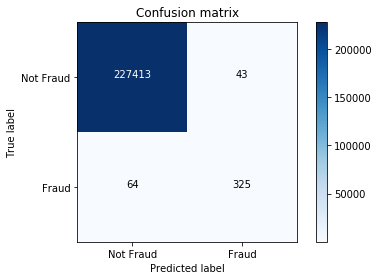

In [35]:
best_thres = recall_thres.iloc[0]['Threshold']
y_train_pred_RF = np.where(RF_train_prob[:,1]>=best_thres,1,0)
cm = confusion_matrix(y_train, y_train_pred_RF)
plot_cm.plot_cm(cm, classes=['Not Fraud','Fraud'])

See how Random Forest performs on test set: 

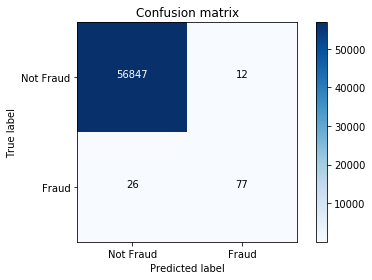

In [36]:
RF_test_prob = RF_gcv.predict_proba(X_test)
y_test_pred = np.where(RF_test_prob[:,1]>=best_thres,1,0)
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plot_cm.plot_cm(cm, classes=['Not Fraud','Fraud'])

In [37]:
print("Recall:", recall_score(y_test, y_test_pred, pos_label=1))
print("Precision:", precision_score(y_test, y_test_pred, pos_label=1))

Recall: 0.7475728155339806
Precision: 0.8651685393258427


### XGBoost
The pipeline of XGBoost including: 
1. Upsampling
2. Training

In [69]:
XGB = Pipeline([('sampling', SMOTE()),
                ('classification', xgb.XGBClassifier())])

# Inverse regularization parameters
XGB_params = {'classification__learning_rate': (0.05, 0.1, 0.15, 0.2, 0.25),
              'classification__max_depth': (3, 4, 5, 6), 
              'classification__gamma': (0, 0.1, 0.2, 0.3, 0.4), 
              'classification__colsample_bytree': (0.3, 0.4, 0.5, 0.6)}

XGB_gcv = RandomizedSearchCV(estimator=XGB, param_distributions=XGB_params, cv=5, scoring='roc_auc')
XGB_gcv.fit(X_train, y_train)

# Get the best score and the best parameter from grid search
print('Best training ROC AUC score:', XGB_gcv.best_score_)
print('Best parameters:', XGB_gcv.best_params_)

Best training ROC AUC score: 0.9809109935550507
Best parameters: {'classification__max_depth': 3, 'classification__learning_rate': 0.1, 'classification__gamma': 0.1, 'classification__colsample_bytree': 0.3}


In [68]:
# Save XGB model
dump(XGB_gcv, 'XGB_gcv.joblib') 

['XGB_gcv.joblib']

In [23]:
# Load XGB model
XGB_gcv = load('XGB_gcv.joblib')

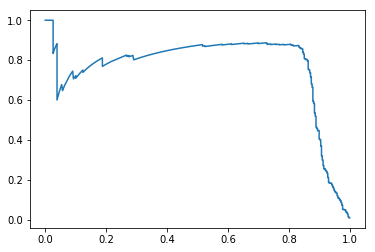

In [24]:
# Predict the probability of class equals to 1
XGB_train_prob = XGB_gcv.predict_proba(X_train)
XGB_Pr, XGB_Rc, XGB_thres = precision_recall_curve(y_train, XGB_train_prob[:,1])
# Plot the PR curve
plt.plot(XGB_Rc, XGB_Pr)

In [30]:
# See which threshold have the best F1 score
beta = 1.5
recall_thres = pd.concat([pd.Series(XGB_thres), pd.Series(XGB_Pr), pd.Series(XGB_Rc), pd.Series((1+beta**2)*XGB_Pr*XGB_Rc/(beta**2*XGB_Pr+XGB_Rc))], axis=1)
recall_thres.columns = ['Threshold', 'Precision', 'Recall', 'F1 Score']

recall_thres.sort_values(by='F1 Score', ascending=False, inplace=True)
recall_thres.head()

,Threshold,Precision,Recall,F1 Score
40394,0.949025,0.856771,0.845758,0.849117
40393,0.947884,0.854545,0.845758,0.848443
40392,0.946387,0.852332,0.845758,0.847770
40395,0.950468,0.856397,0.843188,0.847208
40391,0.946032,0.850129,0.845758,0.847098


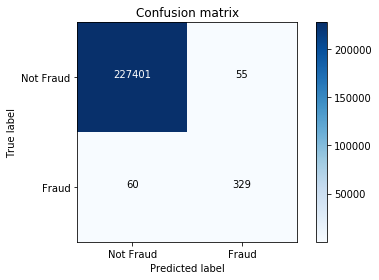

In [31]:
best_thres = recall_thres.iloc[0]['Threshold']
y_train_pred_XGB = np.where(XGB_train_prob[:,1]>=best_thres,1,0)
cm = confusion_matrix(y_train, y_train_pred_XGB)
plot_cm.plot_cm(cm, classes=['Not Fraud','Fraud'])

See how XGBoost performs on test set:

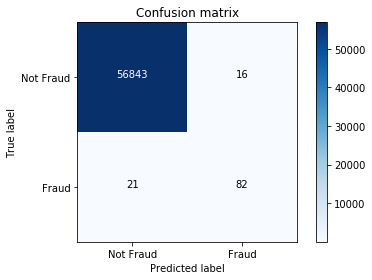

In [32]:
XGB_test_prob = XGB_gcv.predict_proba(X_test)
y_test_pred = np.where(XGB_test_prob[:,1]>=best_thres,1,0)
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plot_cm.plot_cm(cm, classes=['Not Fraud','Fraud'])

In [33]:
print("Recall:", recall_score(y_test, y_test_pred, pos_label=1))
print("Precision:", precision_score(y_test, y_test_pred, pos_label=1))

Recall: 0.7961165048543689
Precision: 0.8367346938775511


## Conclusion
The decision boundaries of tree based models are seperating the feature space into small regions, while the decision boundary of Logistic Regression is just seperating the feature space exactly into two regions by a hyperplane. Tree based models have more complex decision boundaries, which can lead to more superior seperation. However, because of the same reason, a single decision tree may susceptible to overfitting, combining multiple decion trees will alleviate the overfitting. Therefore, the models that are combining multiple decision trees will both have superior seperation and less likely to get overfit. 

From the results above, we can see that XGBoost and Random Forest seperate the data much better than Logistic Regression and Decision Tree. There are less precision-recall trade-off in XGBoost and Random Forest compared to Logistic Regression and Decision Tree. Therefore, XGBoost and Random Forest can improve precision by around 20% compared to Logistic Regression. 

* For precision: Random Forest > XGBoost > Logistic Regression > Decision Tree

* For Recall: XGBoost > Random Forest > Decision Tree = Logistic Regression

As for the running time, although the training time of the four models are all very short (30s to 1min per fit), there are a ton of hyperparameters to tune in Random Forest and XGBoost, while Logistic Regression and Decision Tree have only a few hyperparameter to tune. Therefore, it took us much more time to train Random Forest and XGBoost compared to Logistic Regression and Decision Tree using grid search cross validation. 